# Exercise 5

Work on this before the next lecture on 8 May. We will talk about questions, comments, and solutions during the exercise after the third lecture.

Please do form study groups! When you do, make sure you can explain everything in your own words, do not simply copy&paste from others.

The solutions to a lot of these problems can probably be found with Google. Please don't. You will not learn a lot by copy&pasting from the internet.

If you want to get credit/examination on this course please upload your work to **your GitHub repository** for this course **before** the next lecture starts and post a link to your repository [in this thread](). If you worked on things together with others please add their names to the notebook so we can see who formed groups.

---

These are some useful default imports for plotting and [`numpy`](http://www.numpy.org/)

In [125]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14
from sklearn.utils import check_random_state

## Question 1

You can use PCA as a form of noise filtering. The idea why this might work goes like this: overall the PCA components representing the noise will explain less of the variance in the dataset than the components related to the actual data. So if you keep only the high variance components you can remove (some) of the noise.

* plot some of the digits before and after the noise has been added
* fit a `PCA` transformer to the digit dataset
* experiment with the number of components you need to get a good reconstruction of the digits that supresses the noise.
* (bonus) is there a quantitative way to pick the best number of components?

(Note: You can use this for high dimensional tabular data as well. Instead of training your classifier on all the features you can first transform your data and only use the first "few" components, thereby removing the noise.)

In [126]:
from sklearn.datasets import load_digits
digits = load_digits()

# fluctuate each pixel's intensity by drawing from a gaussian
# with mean equal to the pixels value and std=4
np.random.seed(42)
noisy_digits = np.random.normal(digits.data, 4)

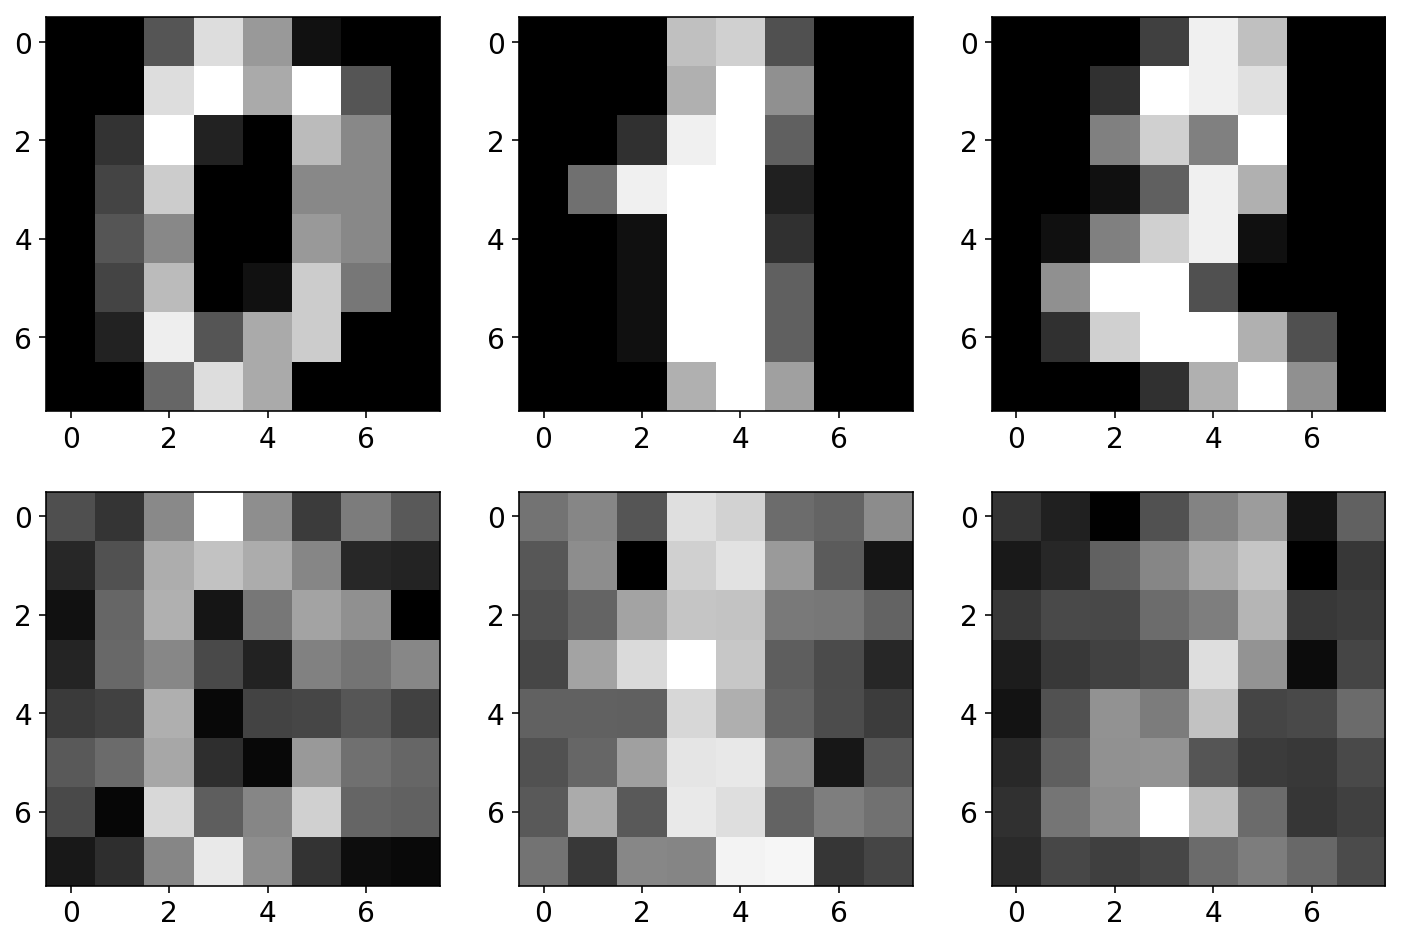

In [129]:
# your answer
# before noise addition
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
paired_digits = np.vstack([digits.data[:3], noisy_digits[:3]])
for digit, ax in zip(paired_digits, axes.flatten()):
    digit = digit.reshape(8, 8)
    ax.imshow(digit, cmap='gray')

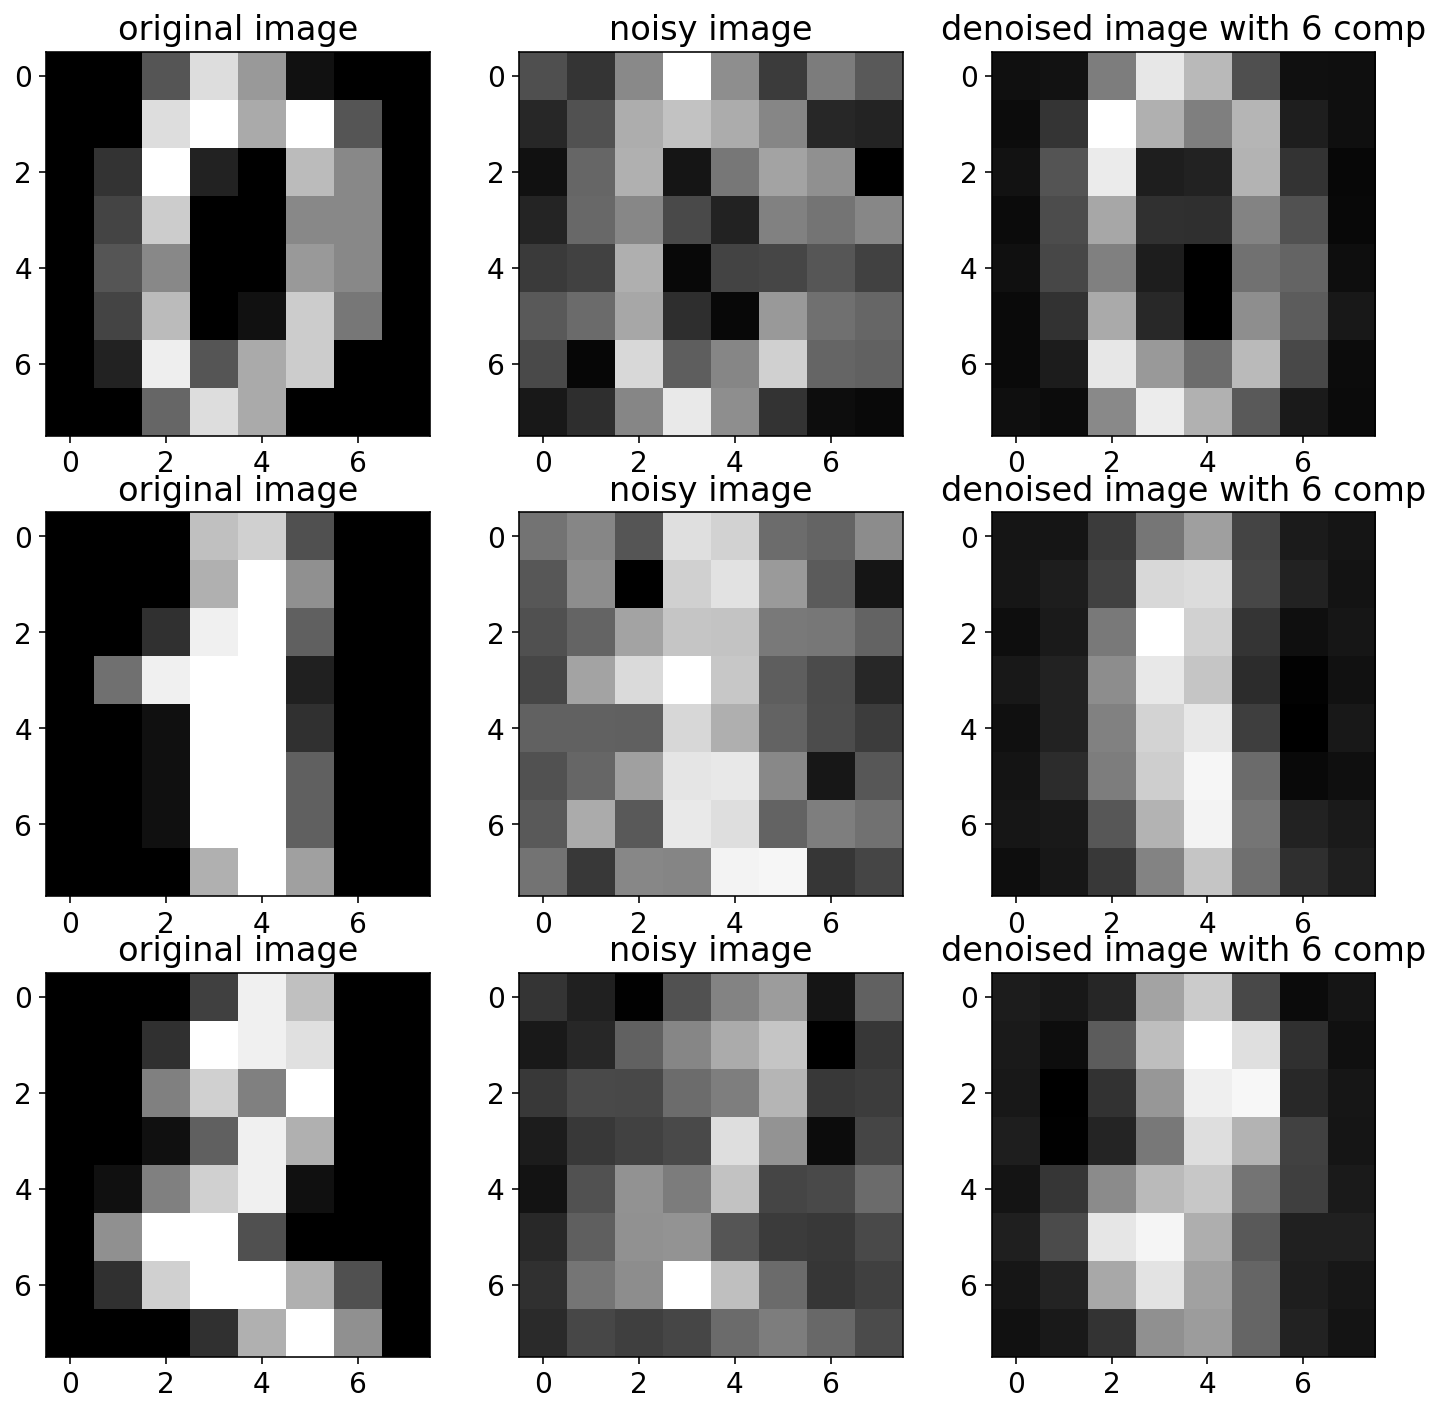

In [130]:
from sklearn.decomposition import PCA
from ipywidgets import interact

def denoise_digits(n_components=6):
    fig, axes = plt.subplots(3, 3, figsize=(3*4, 3*4))
    
    pca = PCA(n_components=n_components)
    pca.fit(noisy_digits)
    
    for original_digit, noisy_digit, ax in zip(digits.data[:3], noisy_digits[:3], axes):
        ax0 = ax[0]
        ax0.imshow(original_digit.reshape(8, 8), cmap='gray')
        ax0.set_title('original image')
        
        ax1 = ax[1]
        ax1.imshow(noisy_digit.reshape(8, 8), cmap='gray')
        ax1.set_title('noisy image')
        
        ax2 = ax[2]
        denoised_digit = pca.transform(noisy_digit.reshape(1, -1))
        denoised_digit = pca.inverse_transform(denoised_digit)
        ax2.imshow(denoised_digit.reshape(8, 8), cmap='gray')
        ax2.set_title('denoised image with %i comp' % n_components)
        
interact(denoise_digits, n_components=(1,65));

Playing with the coefficients, it seems that best choise for the coefficients is 6-7. 

For a quantitative approach, there are several startegies. First, we can look for the answer assuming, that we know the original image without noise. In this case we can look at the resudial image between the original and the reconstructed one. The minimal std of the residual image pixels should correspond to the optimal number of components. 

Then, another possibility would be to assume, that we don't know the original imge, but we know the noise - this is the case for a lot of problems - in astro at least :). Then we would be looking at the residual between the noisy image and the reconstructed image. The distribution in the resudial closest to the noise should give us the answer. 

optimal component to denoise "0" digit is 15
optimal component to denoise "1" digit is 17
optimal component to denoise "2" digit is 17


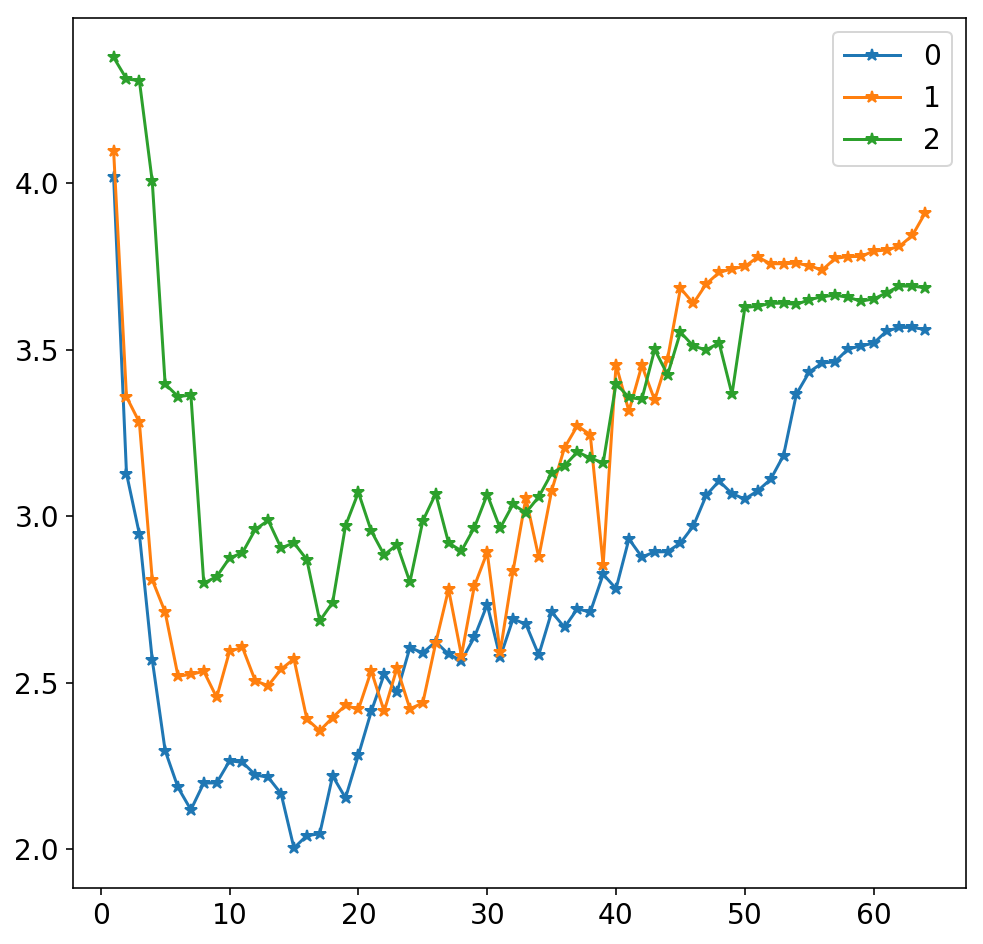

In [131]:
# implementing the first approach with the original image
components = np.arange(1, 65)

def calculating_variance(components):
    pcas = [PCA(n_components=n_components) for n_components in components]
    [pca.fit(noisy_digits) for pca in pcas]
    
    std_of_residuals_per_digit = []
    for original_digit, noisy_digit in zip(digits.data[:3], noisy_digits[:3]):
        reshaped_noisy_digit = noisy_digit.reshape(1, -1)
        denoised_digits = [pca.inverse_transform(pca.transform(reshaped_noisy_digit)) for pca in pcas]
        residuals = list(map(lambda x: original_digit-x, denoised_digits))
        std_of_residuals = list(map(np.std, residuals))
        std_of_residuals_per_digit.append(std_of_residuals)
        
    return std_of_residuals_per_digit
    
stds = calculating_variance(components)
for std, name in zip(stds, ['0', '1', '2']):
    plt.plot(components, std, '*-', label=name)
    ind = np.argmin(std)
    the_component = components[ind]
    print('optimal component to denoise "%s" digit is %i' % (name, the_component))
plt.legend(loc='best')

optimal component to denoise "0" digit is 3
optimal component to denoise "1" digit is 19
optimal component to denoise "2" digit is 13


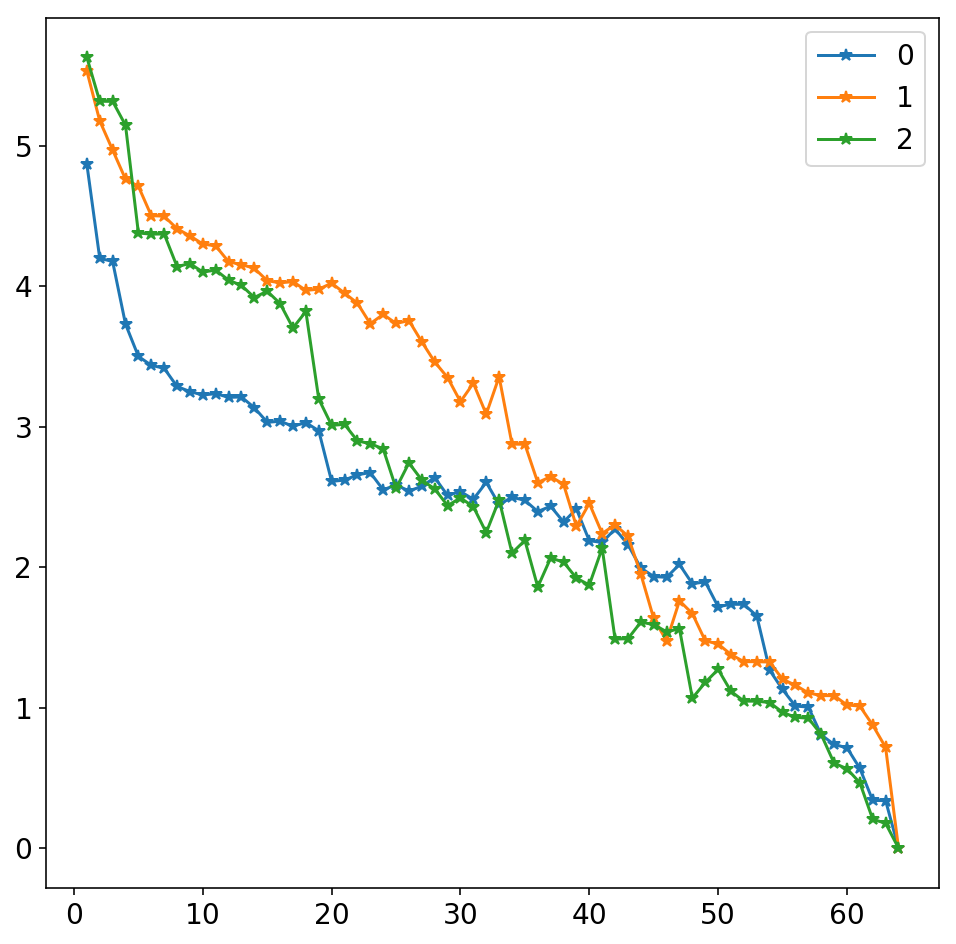

In [132]:
# implementing the second approach with the known noise
components = np.arange(1, 65)

def calculating_variance(components):
    pcas = [PCA(n_components=n_components) for n_components in components]
    [pca.fit(noisy_digits) for pca in pcas]
    
    std_of_residuals_per_digit = []
    for noisy_digit in noisy_digits[:3]:
        reshaped_noisy_digit = noisy_digit.reshape(1, -1)
        denoised_digits = [pca.inverse_transform(pca.transform(reshaped_noisy_digit)) for pca in pcas]
        residuals = list(map(lambda x: noisy_digit-x, denoised_digits))
        std_of_residuals = list(map(np.std, residuals))
        std_of_residuals_per_digit.append(std_of_residuals)
        
    return std_of_residuals_per_digit
    
stds = calculating_variance(components)
for std, name in zip(stds, ['0', '1', '2']):
    plt.plot(components, std, '*-', label=name)
    closest = list(map(lambda x: np.abs(x-4.0), std))
    ind = np.argmin(closest)
    the_component = components[ind]
    print('optimal component to denoise "%s" digit is %i' % (name, the_component))
plt.legend(loc='best')

Second method is not far away from the first one, but is of course less precise, as we posess less information. 

---

## Question 2

Apply PCA to a dataset that contains two gaussian blobs. Imagine this is a toy version of a real problem where you are trying to separate the dark from the light points. Before using the `PCA` transformer make a prediction for the two principle components from your intuition.

* draw the principle components PCA finds
* reduce the dimensionality of the data to one dimension using the `transform` method of the `PCA` transformer
* plot your transformed dataset, can you separate the two classes using only the first principle component?
* A technique related to PCA that makes use of the class labels is called linear discriminant analysis (LDA). How does LDA perform on this problem?
* Can you explain why PCA fails?

I think, that the axes for the pca components would be: one running parallel to big semiaxis of datasets but between the blobs. And the second one will be perpendicular to it. 

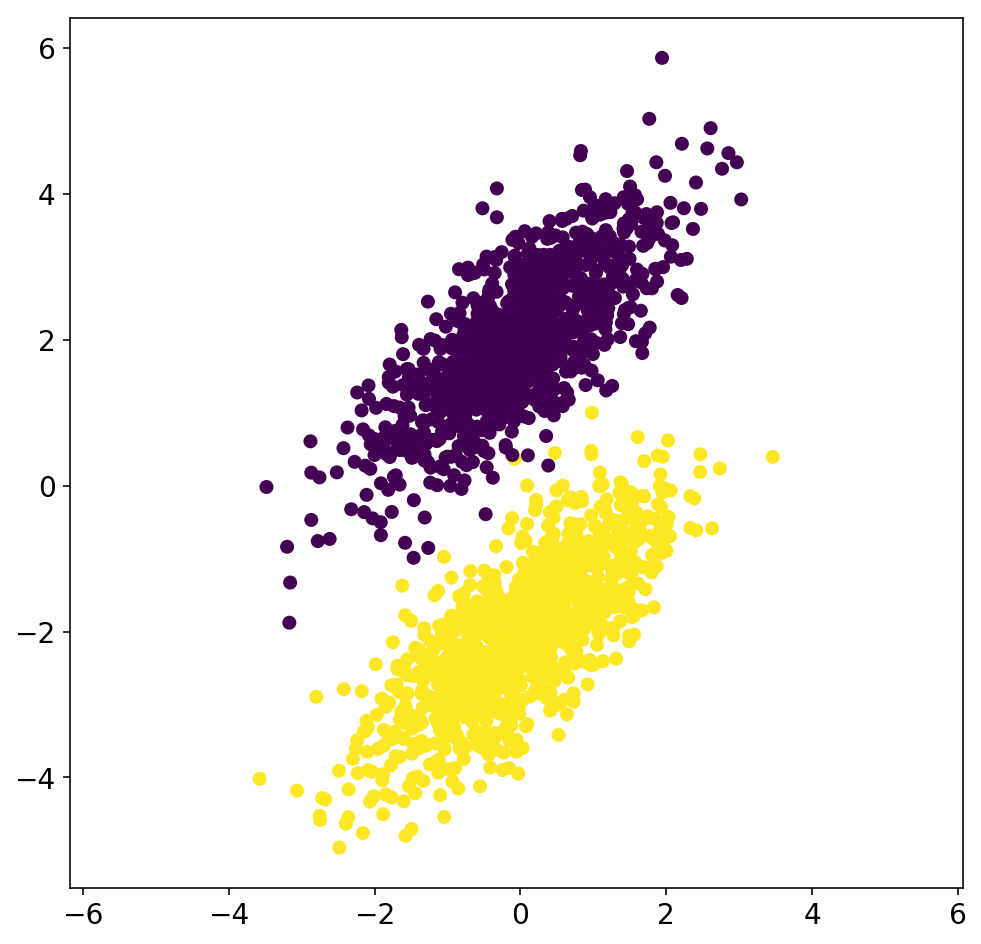

In [133]:
N = 1000
m1 = (1,1)
m2 = (1,4)
C = ((1,0.75), (0.75,1))
g1 = np.random.multivariate_normal((0, -2), C, N)
g2 = np.random.multivariate_normal((0, +2), C, N)

X = np.vstack((g1, g2))
y = np.hstack((np.ones(N), np.zeros(N)))

plt.scatter(X[:,0], X[:,1], c=y)
plt.axis('equal');

In [134]:
# your answer here
pca = PCA()
pca.fit(X)
print(pca.components_, 'comp')
print(pca.explained_variance_, 'var')

[[ 0.17638282  0.98432164]
 [-0.98432164  0.17638282]] comp
[ 5.10917118  0.90313882] var


As there are only two features, pca finds two components. We ca draw then as vectors. 

[ 1.1754452   6.65306603]
[-2.8269236   0.48120781]


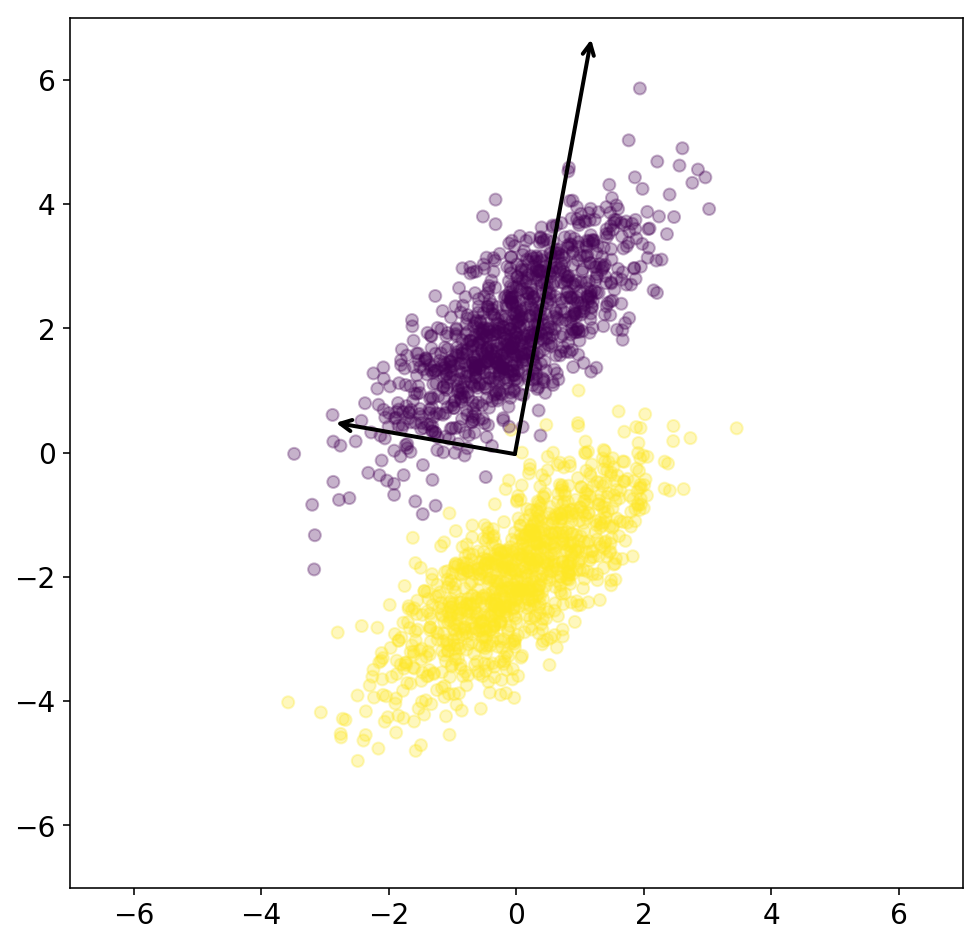

In [135]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.3)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    print(pca.mean_+v)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.ylim([-7, 7])
plt.xlim([-7, 7]);

Well, my intuition was wrong. Partially, because I wasn't looking at the plot with equal axes, as PCA was looking at it. 

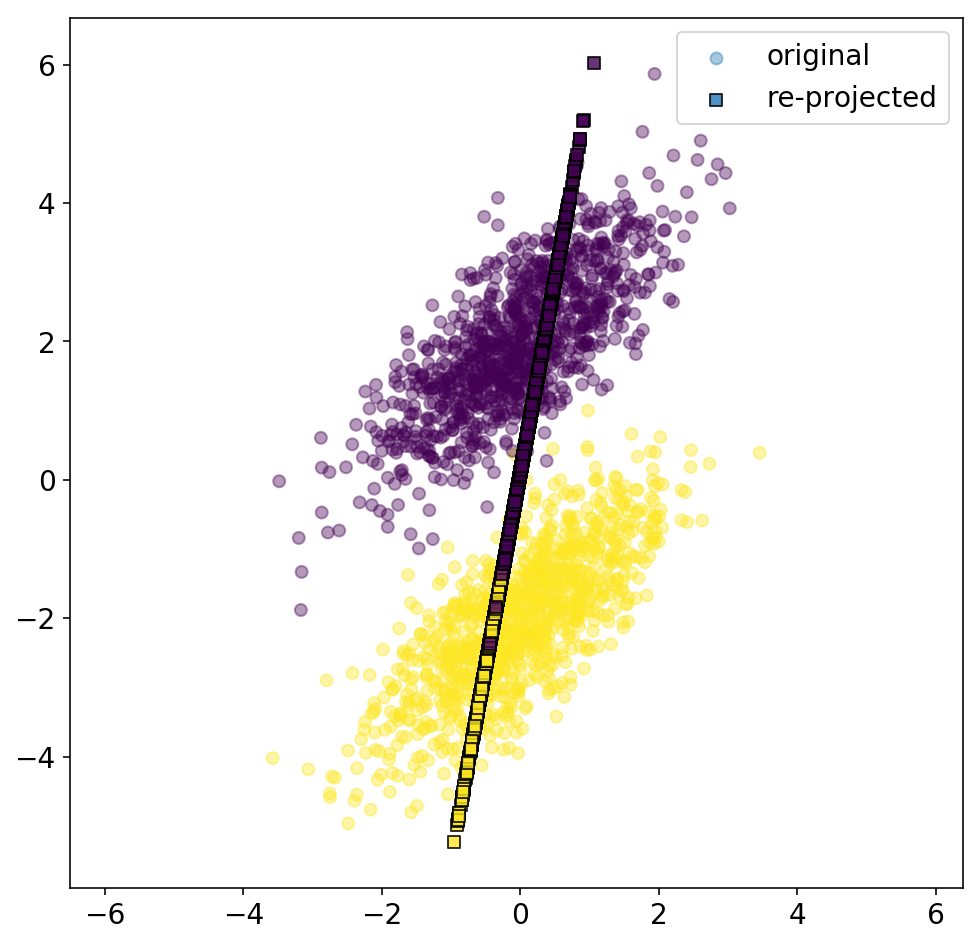

In [136]:
# now reduce components to one
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.4, label='original')
plt.scatter(X_new[:, 0], X_new[:, 1], c=y, marker='s', edgecolor='black', alpha=0.8, label='re-projected')
plt.legend(loc='best')
plt.axis('equal');

In [137]:
# using LDA to slove the problem
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from utils import plot_surface

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
lda = LDA(n_components=1)
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=1, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

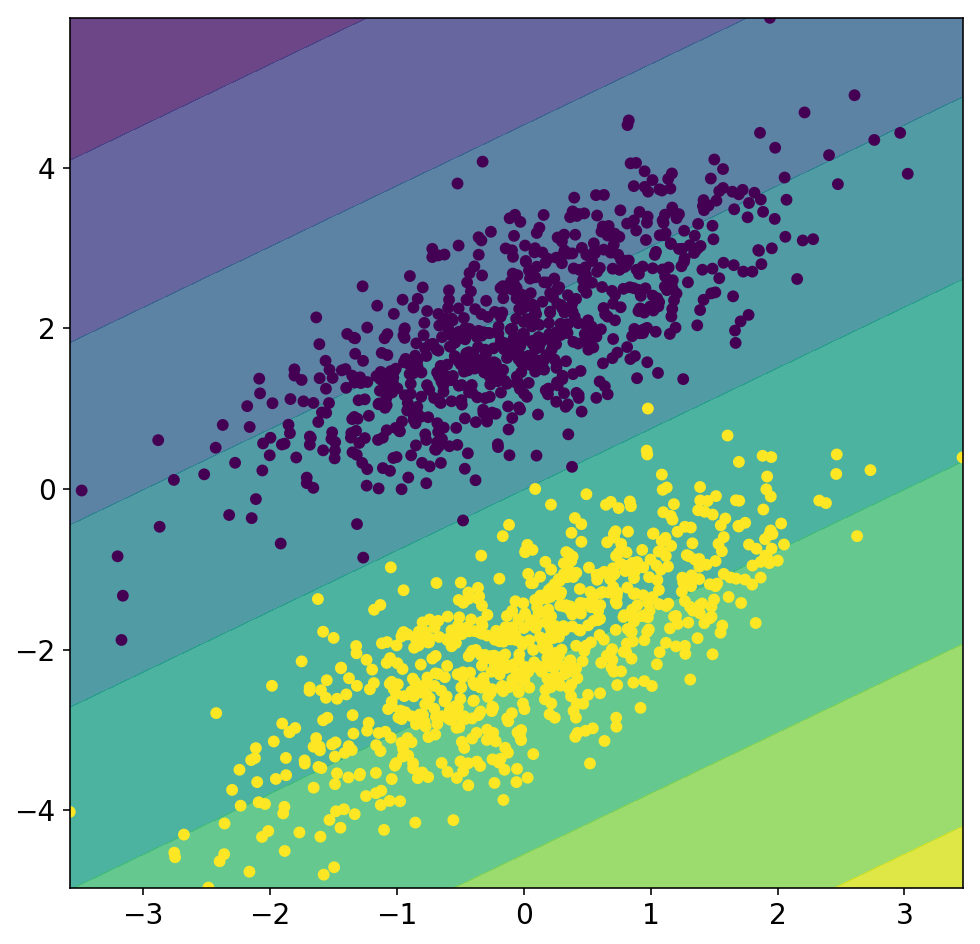

0.996 score


In [138]:
plot_surface(lda, X_train, y_train)
print(lda.score(X_test, y_test), 'score') 

/Users/Olga/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


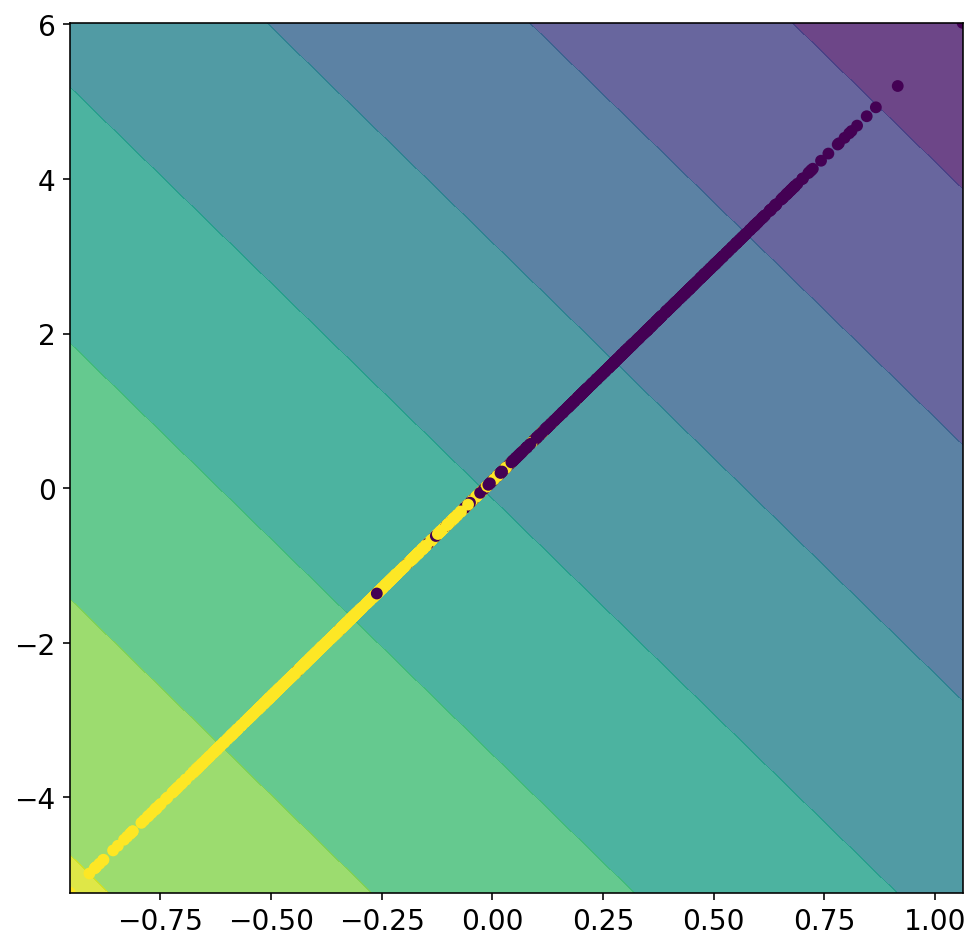

0.95 score


In [139]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=1)
lda = LDA(n_components=1)
lda.fit(X_train, y_train)
plot_surface(lda, X_train, y_train)
print(lda.score(X_test, y_test), 'score') 

LDA perfroms on the data very well. It separates the data well even if we give it the data reduced by PCA. 
PCA doesn't perform well because the biggest variance axes is the diagonal running through both sets. And as it doesn't see the labels, it can't tell the difference.

## Question 3

Create a simple Auto Encoder using `keras`. By forcing the input through a bottleneck we can hope that the auto encoder focusses on interesting structure in the data and ignores noise. Maybe auto encoders can be used to perform denoising.

* create your own auto encoder setup or start from the one shown in the lecture. You might have to construct a auto encoder that has more layers or uses more powerful transformations like `Conv2D`, `MaxPooling2D` and `Upsampling2D`.
* make sure to load the MNIST dataset from `keras` and not the digits dataset from scikit-learn. Create a noisy version of your digits by drawing pixel values from a gaussian with mean equal to each pixel's intensity and a small standard deviation (tip: start with little/no noise to debug your auto encoder and then slowly increase the noise)
* how do you need to modify the learning setup compared to the lecture where we use `X_train` both as input and as output?

(Bonus: can you learn an "auto encoder" that rotates clean digits by 90degrees? This shuold start you off thinking about using neural networks as general purpose "transformers".)

In [140]:
# your answer here
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape and normalise data
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train, X_test = X_train.reshape(-1, 28*28), X_test.reshape(-1, 28*28)
#adding noise
X_train, X_test = np.random.normal(X_train, 0.5), np.random.normal(X_test, 0.5)

In [141]:
# here we construct our autoencoder model
# first we do the simple model as in the lecture
encoding_dim = 32

input_img = Input(shape=(28*28,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(28*28, activation='relu')(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_18 (Dense)             (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [142]:
# here we construct the encoding part
encoder = Model(input_img, encoded)

In [143]:
# here we construct the decoging part
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [146]:
# train the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

model = autoencoder.fit(X_train, X_train,
                        epochs=50,
                        batch_size=256,
                        shuffle=True,
                        verbose=False,
                        validation_data=(X_test, X_test))

In [147]:
print('final valdiation loss (MSE):', model.history['val_loss'][-1])

final valdiation loss (MSE): 0.257703347158


In [148]:
X_encoded = encoder.predict(X_test)
X_decoded = decoder.predict(X_encoded)

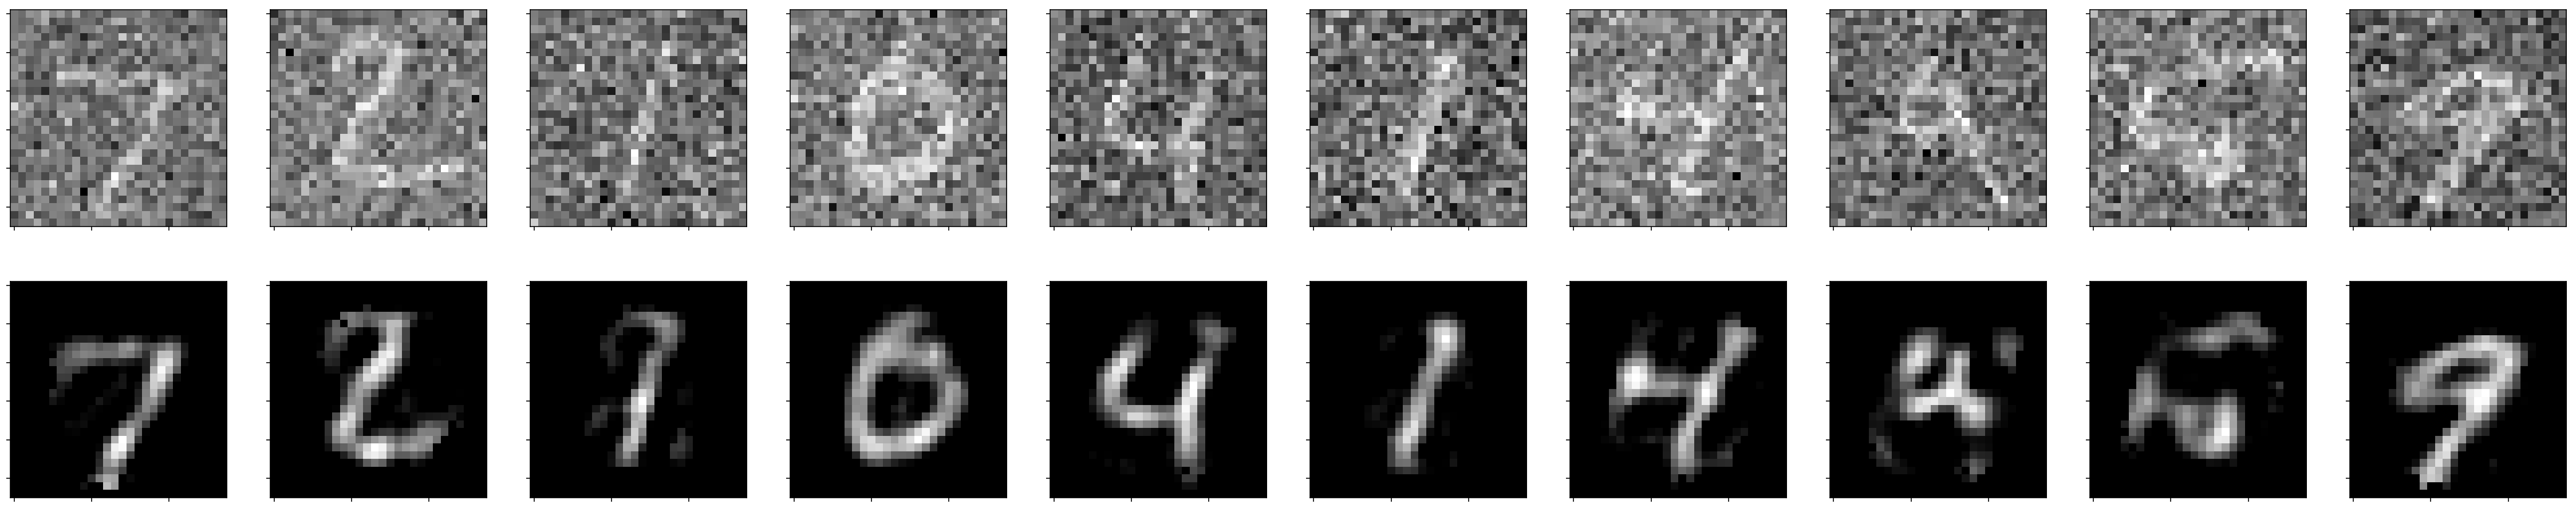

In [149]:
n_images = 10
fig, axs = plt.subplots(2, 10, figsize=(n_images*4, 8))
for i in range(n_images):
    # original
    ax = axs[0, i]
    ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    # reconstruction
    ax = axs[1, i]
    ax.imshow(X_decoded[i].reshape(28, 28), cmap='gray')
    ax.set_yticklabels([])
    ax.set_xticklabels([])

We see, that with little noise, even the simple autoencoder works. Next, we will try something more complicated.
Normally the noise can be removed by smoothing i.e. convolving. So we'll try this.

In [174]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape and normalise data
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
X_test = np.reshape(X_test, (len(X_test), 28, 28, 1))  # adapt this if using `channels_first` image data format
#adding noise
X_train, X_test = np.random.normal(X_train, 0.5), np.random.normal(X_test, 0.5)

In [175]:
# convolutional autoencoder
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

input_img = Input(shape=(28, 28, 1))
#encoded = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
encoded = MaxPooling2D((2,2), padding='same')(input_img)
encoded = Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2,2), padding='same')(encoded)
encoded = Conv2D(4, (3,3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2,2), padding='same')(encoded)

#decoded = Conv2D(4, (2, 2), activation='relu', padding='same')(encoded)
decoded = UpSampling2D((2,2))(encoded)
decoded = Conv2D(4, (3,3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2,2))(decoded)
decoded = Conv2D(8, (3,3), activation='relu')(decoded)
decoded = UpSampling2D((2,2))(decoded)
decoded = Conv2D(1, (3,3), activation='relu', padding='same')(decoded)
#decoded = UpSampling2D((2,2))(decoded)
#decoded = Conv2D(1, (3,3), activation='relu', padding='same')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 14, 14, 1)         0         
_________________________________________________________________
conv2d_155 (Conv2D)          (None, 14, 14, 8)         80        
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_156 (Conv2D)          (None, 7, 7, 4)           292       
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 4, 4, 4)           0         
_________________________________________________________________
up_sampling2d_70 (UpSampling (None, 8, 8, 4)           0         
__________

In [176]:
# train the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

model = autoencoder.fit(X_train, X_train,
                        epochs=50,
                        batch_size=256,
                        shuffle=True,
                        verbose=False,
                        validation_data=(X_test, X_test))

In [177]:
print('final valdiation loss (MSE):', model.history['val_loss'][-1])

final valdiation loss (MSE): 0.278162175083


In [92]:
X_decoded = autoencoder.predict(X_test)

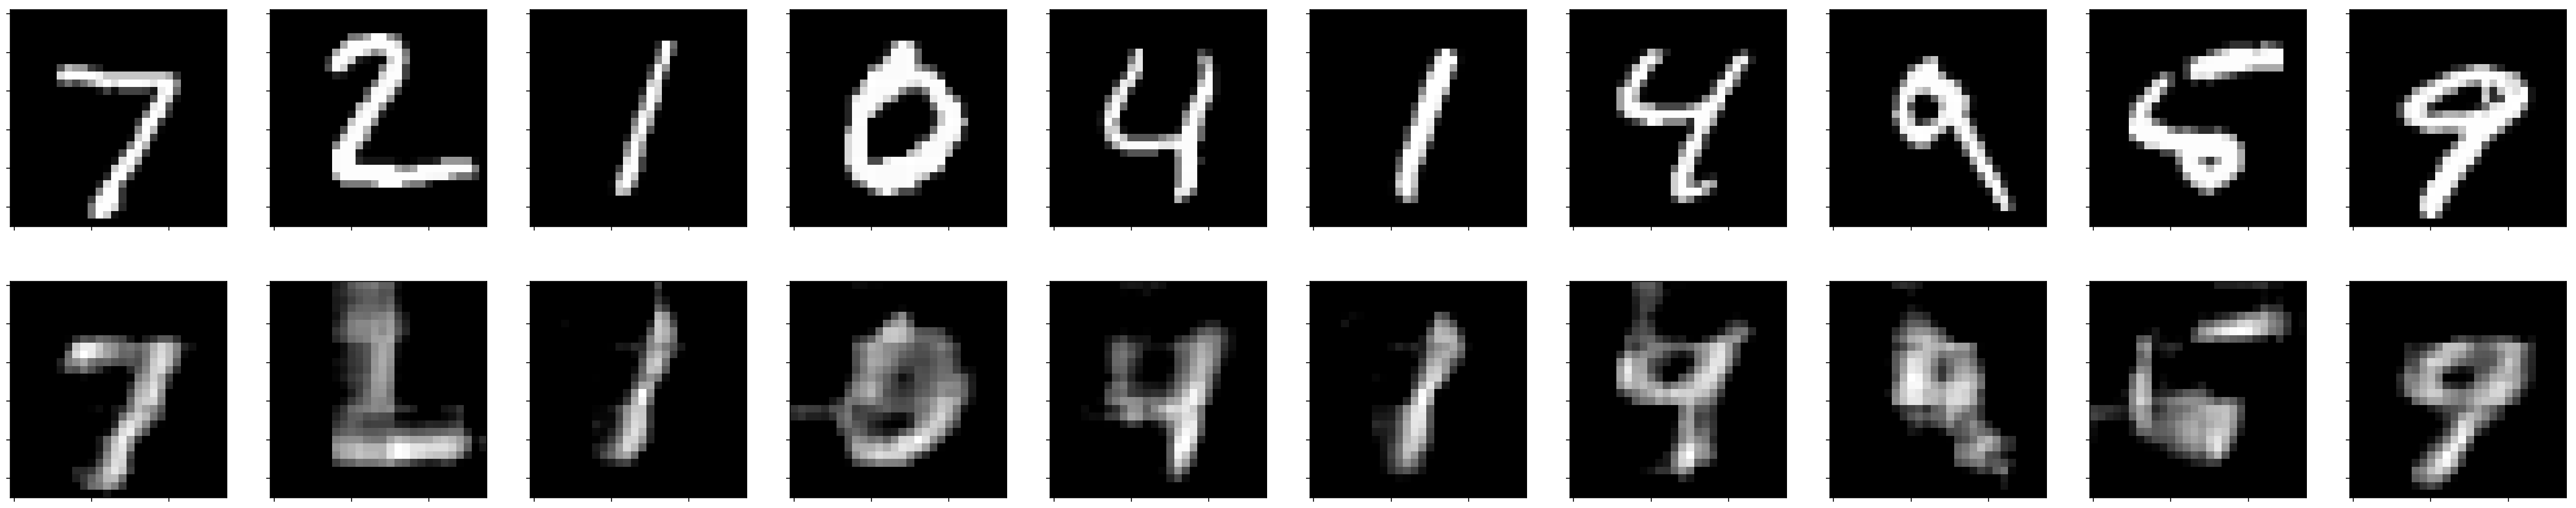

In [93]:
n_images = 10
fig, axs = plt.subplots(2, 10, figsize=(n_images*4, 8))
for i in range(n_images):
    # original
    ax = axs[0, i]
    ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    # reconstruction
    ax = axs[1, i]
    ax.imshow(X_decoded[i].reshape(28, 28), cmap='gray')
    ax.set_yticklabels([])
    ax.set_xticklabels([])

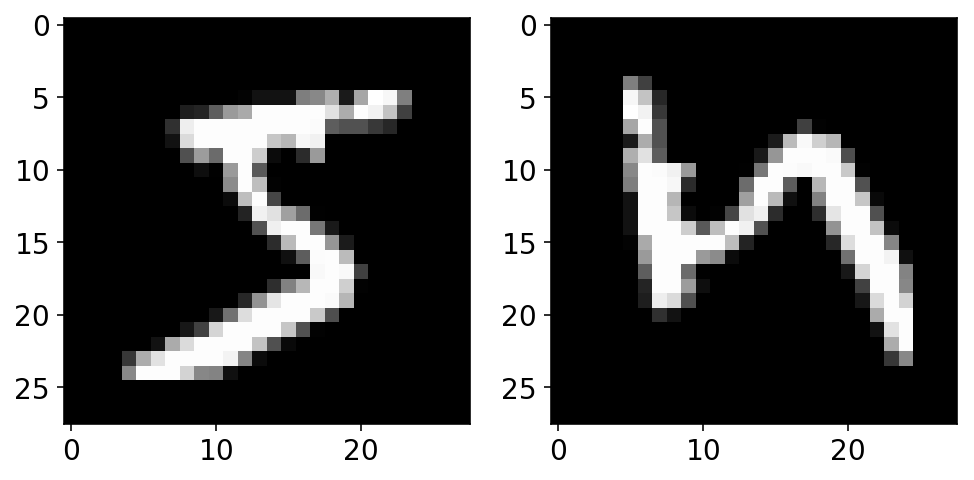

In [168]:
# trying teach autoencoders to rotates images
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape and normalise data
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# making rotated copy of the original images
y_train = np.array([np.rot90(digit.reshape(28, 28)).ravel() for digit in X_train])
y_test = np.array([np.rot90(digit.reshape(28, 28)).ravel() for digit in X_test])

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
digit = X_train[0].reshape(28, 28)
digitT = y_train[0].reshape(28, 28)
ax[0].imshow(digit, cmap='gray')
ax[1].imshow(digitT, cmap='gray')

X_train, X_test = X_train.reshape(-1, 28*28), X_test.reshape(-1, 28*28)
y_train, y_test = y_train.reshape(-1, 28*28), y_test.reshape(-1, 28*28)

In [169]:
# here we construct our autoencoder model
# first we do the simple model as in the lecture
encoding_dim = 32

input_img = Input(shape=(28*28,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(28*28, activation='relu')(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_22 (Dense)             (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [170]:
# train the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

model = autoencoder.fit(X_train, y_train,
                        epochs=50,
                        batch_size=256,
                        shuffle=True,
                        verbose=False,
                        validation_data=(X_test, y_test))

In [171]:
print('final valdiation loss (MSE):', model.history['val_loss'][-1])

final valdiation loss (MSE): 0.0132762832895


In [172]:
X_decoded = autoencoder.predict(X_test)

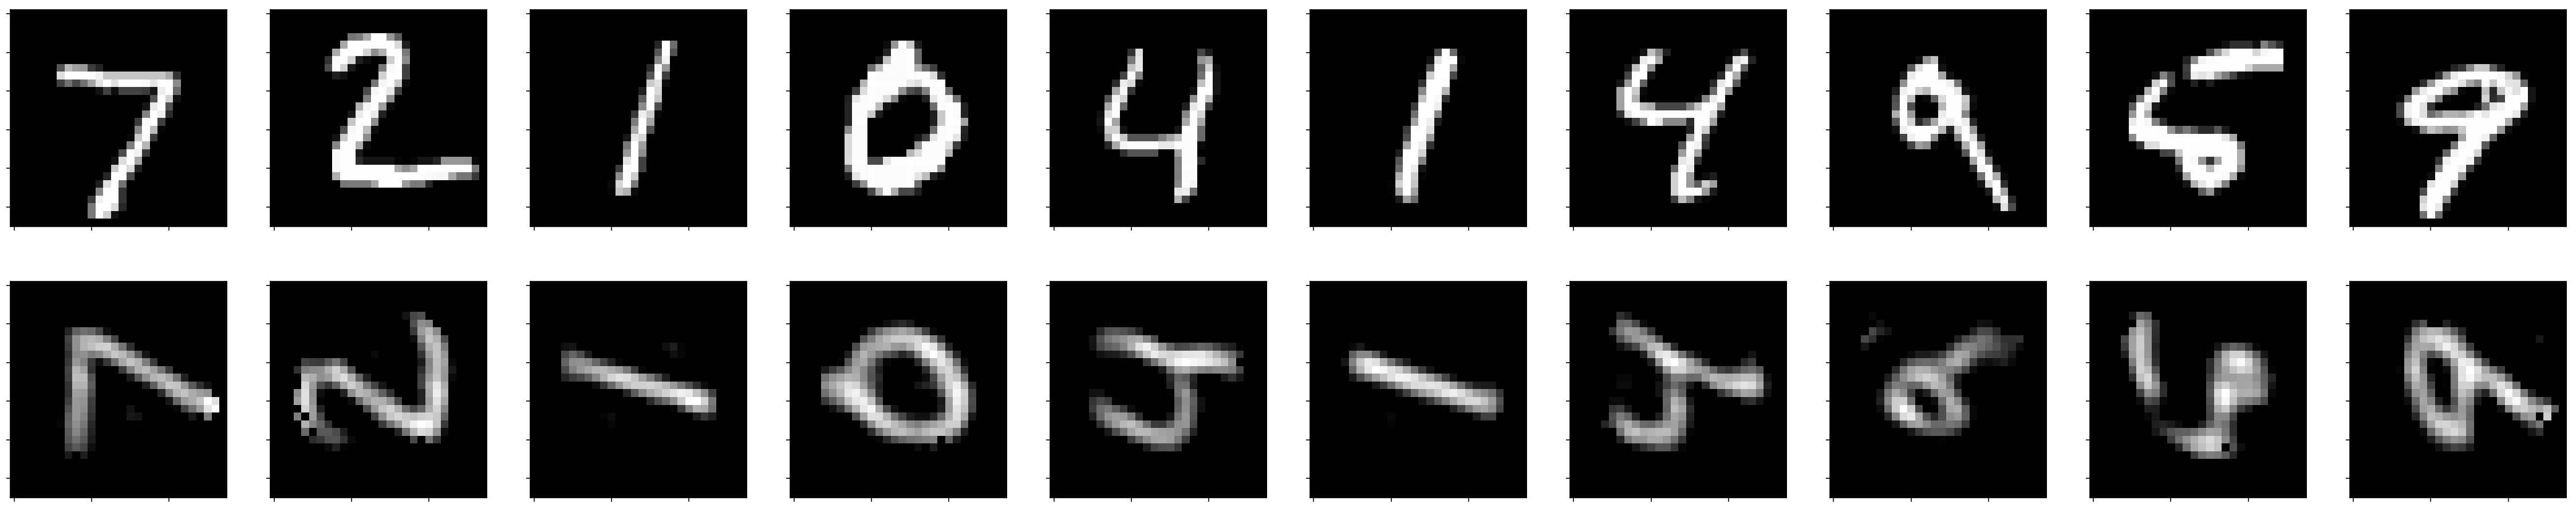

In [173]:
n_images = 10
fig, axs = plt.subplots(2, 10, figsize=(n_images*4, 8))
for i in range(n_images):
    # original
    ax = axs[0, i]
    ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    # reconstruction
    ax = axs[1, i]
    ax.imshow(X_decoded[i].reshape(28, 28), cmap='gray')
    ax.set_yticklabels([])
    ax.set_xticklabels([])

---

## (Bonus) Question 4

Using your auto encoder architecture from the previous question, a clean MNIST dataset, and the ideas from the "visual search" notebook can you create a search engine that can find images similar to the query image?

In [ ]:
# your answer here